In [ ]:
# dataset link
#--https://drive.google.com/drive/folders/1NQXQdAjZGUsjq090vS-KrBGXlrSgMIva?usp=sharing

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_log_error
import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
train=pd.read_csv('/content/Train.csv')
test=pd.read_csv('/content/Test.csv')

train.head()

,Brand,Model_Info,Additional_Description,Locality,City,State,Price
0,1,name0 name234 64gb space grey,1yesr old mobile number 999two905two99 bill c...,878,8,2,15000
1,1,phone 7 name42 name453 new condition box acce...,101004800 1010065900 7000,1081,4,0,18800
2,1,name0 x 256gb leess used good condition,1010010000 seperate screen guard 3 back cover...,495,11,4,50000
3,1,name0 6s plus 64 gb space grey,without 1010020100 id 1010010300 colour 10100...,287,10,7,16500
4,1,phone 7 sealed pack brand new factory outet p...,101008700 10100000 xs max 64 gb made 10100850...,342,4,0,26499


In [ ]:
y=train['Price'].copy(deep=True)

train=train.drop(columns='Price')

train=train.drop(columns='Brand')

train,val,ytrain,yval=train_test_split(train,y,test_size=0.2,random_state=42)

train_numerical=train[['Locality','City','State']]
val_numerical=val[['Locality','City','State']]

train_categorical_one=train['Model_Info']
val_categorical_one=val['Model_Info']

train_categorical_two = train['Additional_Description']
val_categorical_two = val['Additional_Description']

In [ ]:
y

0       15000
1       18800
2       50000
3       16500
4       26499
        ...  
2321    13500
2322     5000
2323     7500
2324    22000
2325    92000
Name: Price, Length: 2326, dtype: int64

In [ ]:
vocab_size=1000
max_length=100
embedding_dims=8
padding_type = 'post'
trunc_type= 'post'
oov_token='<OOV>'


tokenizer1=Tokenizer(num_words=vocab_size,oov_token=oov_token)
tokenizer2=Tokenizer(num_words=vocab_size,oov_token=oov_token)
tokenizer1.fit_on_texts(train_categorical_one)
tokenizer2.fit_on_texts(train_categorical_two)

training_cat_1=tokenizer1.texts_to_sequences(train_categorical_one)
training_cat_1=pad_sequences(training_cat_1,maxlen=max_length,padding=padding_type,truncating=trunc_type)

val_cat_1=tokenizer1.texts_to_sequences(val_categorical_one)
val_cat_1=pad_sequences(val_cat_1,maxlen=max_length,padding=padding_type,truncating=trunc_type)

training_cat_2=tokenizer2.texts_to_sequences(train_categorical_two)
training_cat_2=pad_sequences(training_cat_2,maxlen=max_length,padding=padding_type,truncating=trunc_type)

val_cat_2=tokenizer2.texts_to_sequences(val_categorical_two)
val_cat_2=pad_sequences(val_cat_2,maxlen=max_length,padding=padding_type,truncating=trunc_type)

training_cat_1=np.array(training_cat_1)
val_cat_1=np.array(val_cat_1)
training_cat_2=np.array(training_cat_2)
val_cat_2=np.array(val_cat_2)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
train_num=scaler.fit_transform(train_numerical)
val_num=scaler.transform(val_numerical)

#train_num=train_num.reshape(1860,1,3)



In [ ]:
#val_num=val_num.reshape(466,1,3)

In [ ]:
cat1_input=tf.keras.Input(shape=(100,),name='cat1')
cat2_input=tf.keras.Input(shape=(100,),name='cat2')
num_input=tf.keras.Input(shape=(3,),name='num')

cat1_features=tf.keras.layers.Embedding(vocab_size,embedding_dims,input_length=max_length)(cat1_input)
cat2_features=tf.keras.layers.Embedding(vocab_size,embedding_dims,input_length=max_length)(cat2_input)
cat1_features=tf.keras.layers.GlobalAveragePooling1D()(cat1_features)
cat2_features=tf.keras.layers.GlobalAveragePooling1D()(cat2_features)
#cat1_features=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(cat1_features)
cat1_dense=tf.keras.layers.Dense(64,activation='relu')(cat1_features)
#cat2_features=tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,return_sequences=True))(cat2_features)
cat2_dense=tf.keras.layers.Dense(64,activation='relu')(cat2_features)

num_dense=tf.keras.layers.Dense(64,activation='relu')(num_input)

dense=tf.keras.layers.concatenate([cat1_dense,cat2_dense,num_dense])
#dense=tf.keras.layers.GlobalAveragePooling1D()(dense)

#dense1=tf.keras.layers.concatenate(dense)

output=tf.keras.layers.Dense(1,name='output')(dense)

model=tf.keras.Model(inputs=[cat1_input,cat2_input,num_input],outputs=[output])

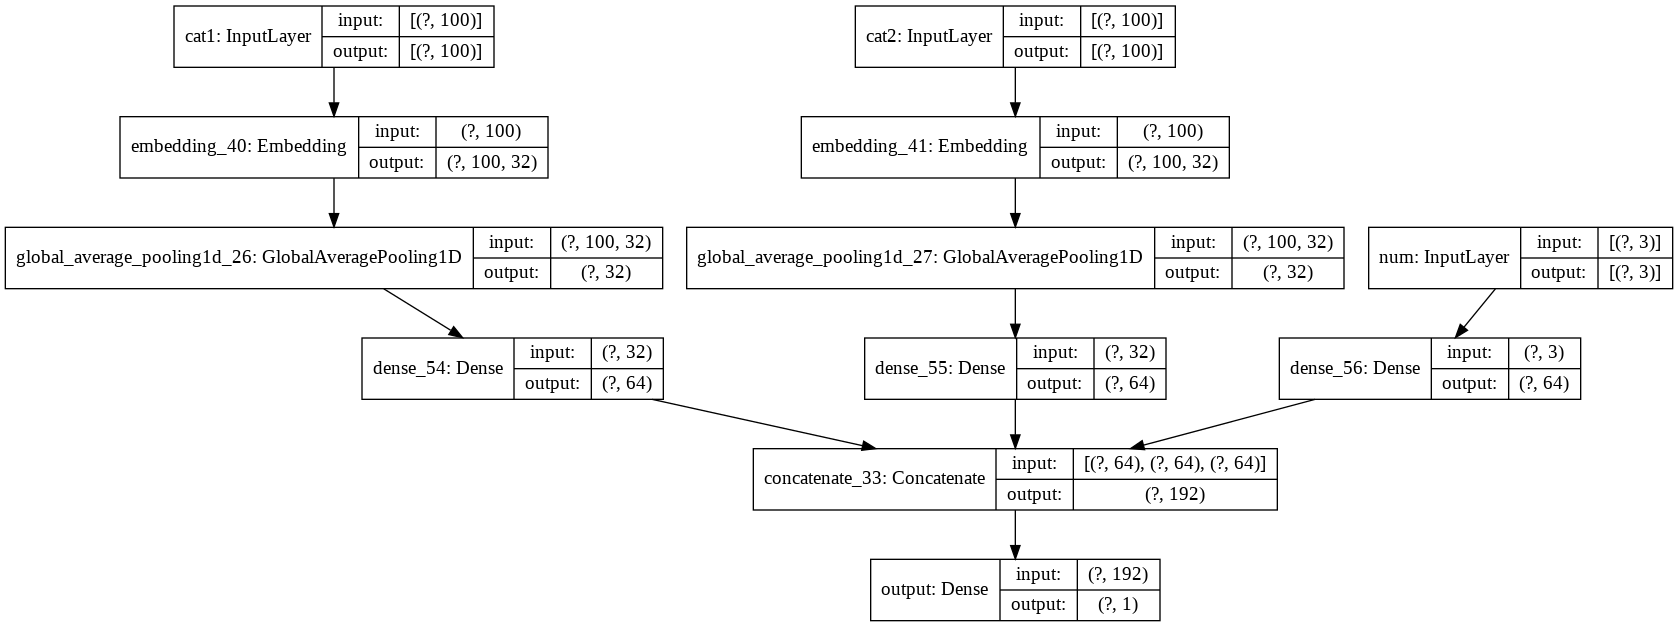

In [ ]:
tf.keras.utils.plot_model(model,'multi input and single output.png',show_shapes=True)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss=tf.keras.losses.MeanSquaredLogarithmicError(),)

In [ ]:
model.fit({'cat1':training_cat_1,'cat2':training_cat_2,'num':train_num},
         {'output':ytrain.values},epochs=500,batch_size=32,validation_data=({'cat1':val_cat_1,'cat2':val_cat_2,'num':val_num},
         {'output':yval.values}))

Epoch 1/500
59/59 [==============================] - 0s 6ms/step - loss: 1.4416 - val_loss: 1.3568
Epoch 2/500
59/59 [==============================] - 0s 7ms/step - loss: 1.4322 - val_loss: 1.3474
Epoch 3/500
59/59 [==============================] - 0s 7ms/step - loss: 1.4227 - val_loss: 1.3380
Epoch 4/500
59/59 [==============================] - 0s 6ms/step - loss: 1.4134 - val_loss: 1.3286
Epoch 5/500
59/59 [==============================] - 0s 7ms/step - loss: 1.4042 - val_loss: 1.3196
Epoch 6/500
59/59 [==============================] - 0s 7ms/step - loss: 1.3950 - val_loss: 1.3104
Epoch 7/500
59/59 [==============================] - 0s 6ms/step - loss: 1.3859 - val_loss: 1.3013
Epoch 8/500
59/59 [==============================] - 0s 6ms/step - loss: 1.3768 - val_loss: 1.2923
Epoch 9/500
59/59 [==============================] - 0s 7ms/step - loss: 1.3680 - val_loss: 1.2834
Epoch 10/500
59/59 [==============================] - 0s 6ms/step - loss: 1.3591 - val_loss: 1.2747
Epoch 11/

In [ ]:
pred=model.predict({'cat1':val_cat_1,'cat2':val_cat_2,'num':val_num})

In [ ]:
np.sqrt(mean_squared_log_error(yval,pred))

0.7952974861291086